## T-type Comparison Study using features, spiral arms, and bulge dominance as proxies for T-type. Limit to z < 0.06 to pretend that depth isn't a factor. 

In [1]:
import numpy as np
from astropy.table import Table,Column,join
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import Image
import ImageOps
from operator import itemgetter
plt.rcParams['text.usetex']=True
import urllib, cStringIO
import random

#function for getting galaxy images
def optical_image(gal):
    
    pixelsize=0.396
    height=500
    width=500

    scale=2.5*gal['PETROR90_R']/pixelsize/width
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(gal['RA'])
    cutOutImageUrl += "&dec=" + str(gal['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    
    file = cStringIO.StringIO(urllib.urlopen(cutOutImageUrl).read())
    img = Image.open(file)    
    return img

def IR_image(gal):
    
    
    file = cStringIO.StringIO(urllib.urlopen(gal['UKIDSS_url']).read())
    img = Image.open(file)    
    return img.crop((100, 100, 424-100, 424-100))


In [5]:
data = Table.read('/home/mel/Documents/gzukidss/data/ukidss_gz2_rh_debiased.fits')


In [3]:

u_dfeatures = 't00_smooth_or_features_a1_features_debiased_rh_ukidss'
g_dfeatures = 't01_smooth_or_features_a02_features_or_disk_debiased_gz2'
u_wfeatures = 't00_smooth_or_features_a1_features_weighted_fraction_ukidss'
g_wfeatures = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction_gz2'


#spiral arm questions:
u_spiral_arm_count = 't03_spiral_count_weighted_ukidss'
g_spiral_arm_count = 't04_spiral_count_gz2'

g_spiral_arm_yes_frac = 't04_spiral_a08_spiral_weighted_fraction_gz2'
gd_spiral_arm_yes_frac = 't04_spiral_a08_spiral_debiased_gz2'
u_spiral_arm_yes_frac = 't03_spiral_a0_spiral_weighted_fraction_ukidss'
ud_spiral_arm_yes_frac = 't03_spiral_a0_spiral_debiased_rh_ukidss'

u_arms_winding_count = 't09_arms_winding_count_weighted_ukidss'
g_arms_winding_count = 't10_arms_winding_count_gz2'


#ukidss arm winding tight fractions
u_tight_arms = 't09_arms_winding_a0_tight_weighted_fraction_ukidss'
ud_tight_arms = 't09_arms_winding_a0_tight_debiased_rh_ukidss'

#gz2 arm winding tight fractions
g_tight_arms = 't10_arms_winding_a28_tight_weighted_fraction_gz2'
gd_tight_arms = 't10_arms_winding_a28_tight_debiased_gz2'


#obvious bulge fractions
u_obv_bulge = 't04_bulge_prominence_a2_obvious_weighted_fraction_ukidss'
ud_obv_bulge = 't04_bulge_prominence_a2_obvious_debiased_rh_ukidss'
g_obv_bulge = 't05_bulge_prominence_a12_obvious_weighted_fraction_gz2'
gd_obv_bulge = 't05_bulge_prominence_a12_obvious_debiased_gz2'

#dominant bulge fractions 
u_dom_bulge = 't04_bulge_prominence_a3_dominant_weighted_fraction_ukidss'
ud_dom_bulge = 't04_bulge_prominence_a3_dominant_debiased_rh_ukidss'
g_dom_bulge = 't05_bulge_prominence_a13_dominant_weighted_fraction_gz2'
gd_dom_bulge = 't05_bulge_prominence_a13_dominant_debiased_gz2'

In [6]:
#redshift and mag cut
data = data[(data['REDSHIFT']<0.06) & (data['PETROMAG_MR']<-20)]

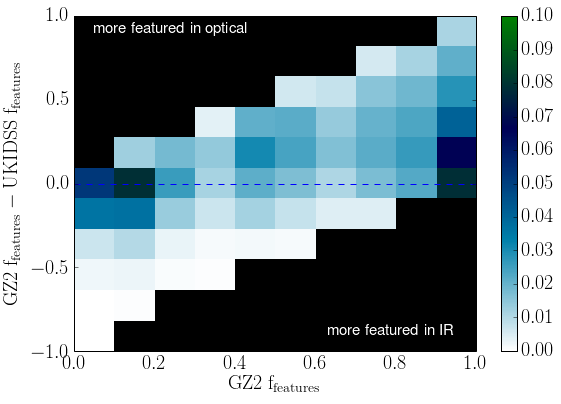

In [15]:
vmin = 0
vmax = 0.1
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

cmap= plt.cm.ocean_r
bin_range=((0,1),(-1,1))
bins=(10,11)
f=plt.figure(figsize=(9,6))
ax=plt.subplot()
nhist,xedges,yedges = np.histogram2d(data[g_dfeatures],data[g_dfeatures]-data[u_dfeatures],range=bin_range,bins=bins)
hist=nhist/np.sum(nhist)

#mask out impossible values (ie if gz2 = 1, gz2 - ukidss must be >0, etc. )
mask_hist = np.zeros(shape=bins)


for i,x in enumerate(xedges[:-1]):
    for j,y in enumerate(yedges[:-1]):
        if (x-y) <0 or (x-y) >1:
            mask_hist[i,j]=1

hist=np.ma.array(hist,mask=mask_hist>0)
cmap= plt.cm.ocean_r
cmap.set_bad('black')

extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(hist.T,origin='lower',extent=extent,interpolation='nearest',aspect='auto',cmap=cmap,vmin=vmin,vmax=vmax)
plt.ylim(-1,1)
ax.text(.05,.9,'more featured in optical',color='white',fontsize=15)
ax.text(.95,-.9,'more featured in IR',color='white',fontsize=15,horizontalalignment='right')
plt.axhline(y=0,ls='dashed')
plt.ylabel('$\mathrm{ GZ2~f_{features} - UKIDSS~f_{features}}$',fontsize=20)
plt.xlabel('$\mathrm{GZ2~f_{features}}$',fontsize=20)
plt.colorbar()
plt.savefig('figures/delta_features.pdf')

# Next: Look at change in type of just spirals, defining spirals as at least 10 people answered "yes" to galaxy having spiral arms in optical and IR


1) Spirals detected in both

2) Spirals detected in optical but not IR

3) Spirals detected in IR but not optical

In [44]:
#Spiral definition: At least 10 people answer question, and at least 40% detect spiral arms
N_spiral = 10
f_spiral = 0.4
optical_spiral = (data[g_spiral_arm_count]>=N_spiral) & (data[gd_spiral_arm_yes_frac]>f_spiral)
optical_not_spiral = (data[g_spiral_arm_count]<N_spiral) | (data[gd_spiral_arm_yes_frac]<f_spiral)
IR_spiral = (data[u_spiral_arm_count]>=N_spiral) & (data[ud_spiral_arm_yes_frac]>f_spiral)
IR_not_spiral = (data[u_spiral_arm_count]<N_spiral) | (data[ud_spiral_arm_yes_frac]<f_spiral)

In [45]:
print 'Total Galaxies with spiral arms in optical: {}'.format(len(data[optical_spiral]))
print 'Total Galaxies with spiral arms in IR: {}'.format(len(data[IR_spiral]))
print 'Galaxies with spiral arms in optical and IR: {}'.format(len(data[optical_spiral & IR_spiral]))
print 'Galaxies with spiral arms in optical and not IR: {}'.format(len(data[optical_spiral & IR_not_spiral]))
print 'Galaxies with spiral arms in IR and not optical: {}'.format(len(data[IR_spiral & optical_not_spiral]))

Total Galaxies with spiral arms in optical: 3767
Total Galaxies with spiral arms in IR: 2395
Galaxies with spiral arms in optical and IR: 2112
Galaxies with spiral arms in optical and not IR: 1655
Galaxies with spiral arms in IR and not optical: 283


# Galaxies which show some spiral structure in both wavelengths - how does the tightness and bulge dominance change?

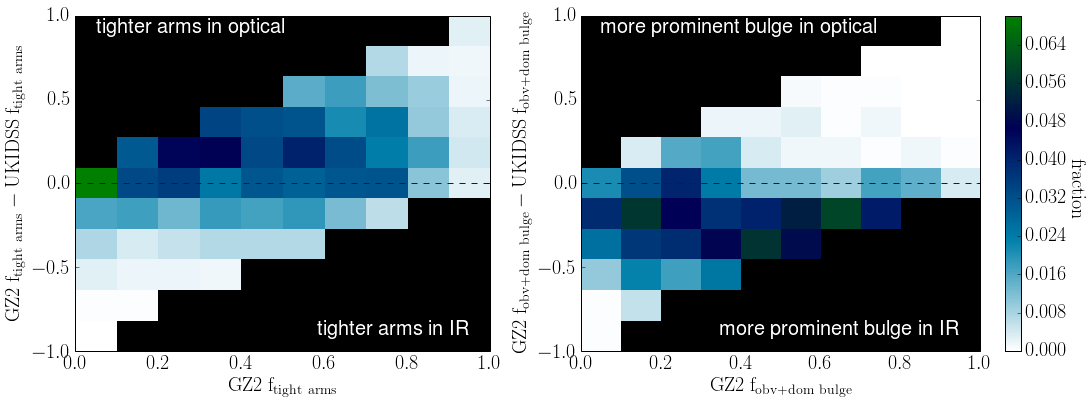

In [46]:
vmin = 0
vmax = 0.07
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

spirals = data[optical_spiral & IR_spiral]

cmap= plt.cm.ocean_r
bins_range=((0,1),(-1,1))
bins=(10,11)
f=plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1.2])
ax=plt.subplot(gs[0,0])
nhist,xedges,yedges = np.histogram2d(spirals[gd_tight_arms],spirals[gd_tight_arms]-spirals[ud_tight_arms],range=bins_range,bins=bins)
hist=nhist/np.sum(nhist)

#mask out impossible values (ie if gz2 = 1, gz2 - ukidss must be >0, etc. )
mask_hist = np.zeros(shape=bins)


for i,x in enumerate(xedges[:-1]):
    for j,y in enumerate(yedges[:-1]):
        if (x-y) <0 or (x-y) >1:
            mask_hist[i,j]=1

hist=np.ma.array(hist,mask=mask_hist>0)
cmap= plt.cm.ocean_r
cmap.set_bad('black')


extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(hist.T,origin='lower',extent=extent,interpolation='nearest',aspect='auto',cmap=cmap,vmin=vmin,vmax=vmax)
plt.ylim(-1,1)
ax.text(.05,.9,'tighter arms in optical',color='white',fontsize=20)
ax.text(.95,-.9,'tighter arms in IR',color='white',fontsize=20,horizontalalignment='right')
plt.axhline(y=0,ls='dashed')
plt.ylabel('$\mathrm{ GZ2~f_{tight~arms} - UKIDSS~f_{tight~arms}}$',fontsize=20)
plt.xlabel('$\mathrm{GZ2~f_{tight~arms}}$',fontsize=20)

ax=plt.subplot(gs[0,1])
nhist,xedges,yedges = np.histogram2d(spirals[gd_obv_bulge]+spirals[gd_dom_bulge],(spirals[gd_obv_bulge]+spirals[gd_dom_bulge])-(spirals[u_obv_bulge]+spirals[u_dom_bulge]),range=range,bins=bins)
hist=nhist/np.sum(nhist)

hist=np.ma.array(hist,mask=mask_hist>0)
cmap= plt.cm.ocean_r
cmap.set_bad('black')



extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(hist.T,origin='lower',extent=extent,interpolation='nearest',aspect='auto',cmap=cmap,vmin=vmin,vmax=vmax)
plt.ylim(-1,1)
ax.text(.05,.9,'more prominent bulge in optical',color='white',fontsize=20)
ax.text(.95,-.9,'more prominent bulge in IR',color='white',fontsize=20,horizontalalignment='right')
plt.axhline(y=0,ls='dashed')
plt.ylabel('$\mathrm{ GZ2~f_{obv+dom~bulge} - UKIDSS~f_{obv+dom~bulge}}$',fontsize=20)
plt.xlabel('$\mathrm{GZ2~f_{obv+dom~bulge}}$',fontsize=20)
plt.colorbar()

f.text(.89,.5,'$\mathrm{fraction}$',rotation=270,fontsize=20,verticalalignment='center')

plt.savefig('figures/delta_tight_arms.pdf')

In [ ]:
optical_spiral_not_IR = optical_spiral & IR_not_spiral
IR_spiral_not_optical = IR_spiral & optical_not_spiral

gs=gridspec.GridSpec(25,4)
gs.update(wspace=0)
gs.update(hspace=0.01)

#data_criteria= optical_spiral_not_IR
data_criteria = IR_spiral_not_optical
these_data=data[data_criteria]

if len(these_data) < 20:
    print 'try new values'

#shuffle which galaxies get displayed     
n_list=np.linspace(0,len(these_data)-1,len(these_data))
#random.seed(3)
random.shuffle(n_list)

#how many galaxies to display?
n_gals = 50
random_n_list = n_list[0:n_gals]

random_gal_list = []
for n in random_n_list:
    random_gal_list.append(these_data[int(n)])
    
labels = np.linspace(1,50,50)

#now we have a random list of galaxies -sort by something
indx = data.colnames.index(ud_spiral_arm_yes_frac)
random_gal_list.sort(key=itemgetter(indx))

f=plt.figure(figsize=(25,175))
n=0
for i in range(0,25):
    gal = random_gal_list[n] # random galaxy from big list 
    
    ax=plt.subplot(gs[i,0])#left-most is gz2 image
    plt.imshow(optical_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')

    ax.annotate('$\mathrm{N_{spiral}: %s}$'%round(gal[g_spiral_arm_count],0),fontsize=38,xy=(0.02,.97),
        xycoords='axes fraction',verticalalignment='top',color='white')
    ax.annotate('$\mathrm{f_{spiral,yes}: %s}$'%round(gal[gd_spiral_arm_yes_frac],2),fontsize=38,xy=(0.02,.02),
        xycoords='axes fraction',color='white')
    
    ax = plt.subplot(gs[i,1]) #right is ukidss image
    plt.imshow(IR_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')

    ax.annotate('$\mathrm{N_{spiral}: %s}$'%round(gal[u_spiral_arm_count],0),fontsize=38,xy=(0.02,.97),
        xycoords='axes fraction',verticalalignment='top',color='white')
    ax.annotate('$\mathrm{f_{spiral,yes}: %s}$'%round(gal[ud_spiral_arm_yes_frac],2),fontsize=38,xy=(0.02,.02),
        xycoords='axes fraction',color='white')
    
    #2nd column
    gal = random_gal_list[n+1] # random galaxy from big list 
    
    ax=plt.subplot(gs[i,2])#left-most is gz2 image
    plt.imshow(optical_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.axvline(x=0,c='w',lw=3)
    ax.annotate('$\mathrm{N_{spiral}: %s}$'%round(gal[g_spiral_arm_count],0),fontsize=38,xy=(0.02,.97),
        xycoords='axes fraction',verticalalignment='top',color='white')
    ax.annotate('$\mathrm{f_{spiral,yes}: %s}$'%round(gal[gd_spiral_arm_yes_frac],2),fontsize=38,xy=(0.02,.02),
        xycoords='axes fraction',color='white')
    
    ax = plt.subplot(gs[i,3]) #right is ukidss image
    plt.imshow(IR_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')
    
    ax.annotate('$\mathrm{N_{spiral}: %s}$'%round(gal[u_spiral_arm_count],0),fontsize=38,xy=(0.02,.97),
        xycoords='axes fraction',verticalalignment='top',color='white')
    ax.annotate('$\mathrm{f_{spiral,yes}: %s}$'%round(gal[ud_spiral_arm_yes_frac],2),fontsize=38,xy=(0.02,.02),
        xycoords='axes fraction',color='white')
    
    n+=2
        
f.text(.5,.92,'Spirals in IR but not optical', fontsize=40,ha='center')

plt.savefig('figures/IR_spiral_not_optical.pdf')
